In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple, List
from statistics import median, mean
import warnings
import math

warnings.filterwarnings("ignore")
pd.set_option("display.max_rows", 300)
sns.set()

C:\Users\luca5\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\luca5\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\.libs\libopenblas.IPBC74C7KURV7CB2PKT5Z5FNR3SIBV4J.gfortran-win_amd64.dll
C:\Users\luca5\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  stacklevel=1)


#### In this notebook I will explore the data and make some decisions to remove/change data based on it.

In [3]:
transactions = pd.read_csv('data/transactions.csv')
accounts = pd.read_csv('data/accounts.csv')
users = pd.read_csv('data/users.csv')
transactions.dropna()
accounts.dropna()
users.dropna(subset=['id', 'update_date'])

transactions['date'] = pd.to_datetime(transactions['date'])
users['update_date'] = pd.to_datetime(users['update_date'])

print(transactions)
print(transactions.describe())

             date   amount  account_id
0      2019-12-16   -29.09           1
1      2019-12-16   160.00           1
2      2019-12-16   -14.00           1
3      2019-12-17   -94.50           1
4      2019-12-17    50.00           1
...           ...      ...         ...
191393 2020-09-22    -2.40         440
191394 2020-09-22   106.73         440
191395 2020-09-22  2168.50         440
191396 2020-09-22  -106.73         440
191397 2020-09-24  -257.00         440

[191398 rows x 3 columns]
              amount     account_id
count  191398.000000  191398.000000
mean        3.902326     224.494054
std      1202.288020     127.191401
min    -82201.680000       0.000000
25%       -53.700000     110.000000
50%       -15.900000     226.000000
75%        -2.000000     337.000000
max     83340.000000     440.000000


#### Remove accounts with less than 6 months of history

In [4]:
def remove_invalid_accounts(df_transactions: pd.DataFrame, threshold: int) -> Tuple[pd.DataFrame, List[int], List[int]]:
    oldest_transactions = df_transactions.groupby(by='account_id').agg({'date': 'min'})
    latest_transactions = df_transactions.groupby(by='account_id').agg({'date': 'max'})

    invalid_account_ids = []

    for i, oldest_date in oldest_transactions.itertuples():
        account_id = accounts.loc[accounts['id']==int(i)]
        user_id = account_id['user_id']
        update_date = users.loc[users['id']==int(user_id)]['update_date'].values[0]
        
        if (oldest_date + pd.Timedelta(threshold, "D") >= update_date):
            invalid_account_ids.append(i)


    df_transactions = df_transactions[~df_transactions['account_id'].isin(invalid_account_ids)]
    
    return df_transactions, invalid_account_ids

In [5]:
THRESHOLD = 183
valid_transactions, invalid_account_ids = remove_invalid_accounts(transactions, THRESHOLD)

print(f"Number of transactions before: {transactions.shape[0]}")
print(f"Number of transactions after: {valid_transactions.shape[0]}")
print(f"Percentage Gone: {int((transactions.shape[0] - valid_transactions.shape[0])/transactions.shape[0]*100)}%\n")
      
valid_accounts = accounts.loc[~accounts['id'].isin(invalid_account_ids)]
print(f"Number of accounts before: {accounts.shape[0]}")
print(f"Number of accounts after: {valid_accounts.shape[0]}")
print(f"Percentage Gone: {int((accounts.shape[0] - valid_accounts.shape[0])/accounts.shape[0]*100)}%\n")

valid_users = users.loc[users['id'].isin(valid_accounts['user_id'].unique())]
print(f"Number of users before: {users.shape[0]}")
print(f"Number of users after: {valid_users.shape[0]}")
print(f"Percentage Gone: {int((users.shape[0] - valid_users.shape[0])/users.shape[0]*100)}%")


Number of transactions before: 191398
Number of transactions after: 167869
Percentage Gone: 12%

Number of accounts before: 441
Number of accounts after: 289
Percentage Gone: 34%

Number of users before: 343
Number of users after: 258
Percentage Gone: 24%


In [6]:
print(valid_transactions)

             date  amount  account_id
0      2019-12-16  -29.09           1
1      2019-12-16  160.00           1
2      2019-12-16  -14.00           1
3      2019-12-17  -94.50           1
4      2019-12-17   50.00           1
...           ...     ...         ...
191363 2020-09-23  -15.99         439
191364 2020-09-24   -1.70         439
191365 2020-09-24  -20.00         439
191366 2020-09-24  -20.00         439
191367 2020-09-25   -1.20         439

[167869 rows x 3 columns]


#### Check that no transactions happened after the update_date

In [7]:
valid_accounts = valid_accounts.loc[valid_accounts["id"].isin(valid_transactions["account_id"])]
user_accounts = valid_accounts.join(users.set_index('id'), 'user_id').set_index('id')
user_accounts_transactions = valid_transactions.join(user_accounts, 'account_id')
print(user_accounts_transactions.loc[
    user_accounts_transactions['date'] > user_accounts_transactions['update_date']])

Empty DataFrame
Columns: [date, amount, account_id, balance, user_id, update_date, business_NAF_code]
Index: []


In [8]:
print(valid_transactions)

             date  amount  account_id
0      2019-12-16  -29.09           1
1      2019-12-16  160.00           1
2      2019-12-16  -14.00           1
3      2019-12-17  -94.50           1
4      2019-12-17   50.00           1
...           ...     ...         ...
191363 2020-09-23  -15.99         439
191364 2020-09-24   -1.70         439
191365 2020-09-24  -20.00         439
191366 2020-09-24  -20.00         439
191367 2020-09-25   -1.20         439

[167869 rows x 3 columns]


#### Visualize data distribution for the transactions

Text(0.5, 1.0, 'Distribution of the transactions amount')

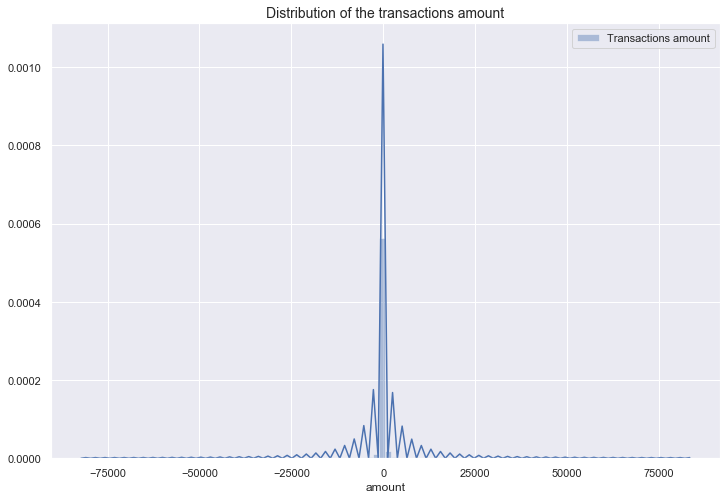

In [9]:
plt.figure(figsize=(12, 8))
sns.distplot(valid_transactions["amount"],
             label="Transactions amount", bins=100)
plt.legend()
plt.title("Distribution of the transactions amount", fontsize=14)

Looks like a mean around 0, symmetric, and with extreme outliers. No need to standardize since all numerical independant variables have the same unit. First I thought it was ideal get closer to a normal distribution and reduce kurtosis and skewness, so we should remove extreme outliers based on mean and std of whole data. Getting closer to a normal distribution is ideal for many statistics inferences (like linear regression). But then I applied another technique.

Mean: 4.0711778827538145
Median: -15.74
Standard Deviation: 1202.6474292156104
Kurtosis: 668.7905488883197
Skew: 7.5511663748735955

Mean: -32.16511002019983
Median: -15.9
Standard Deviation: 585.9674286394586
Kurtosis: 37.48617923252155
Skew: 0.677227009301311

Number of transactions after: 166833
Percentage Gone: 0.62%


Text(0.5, 1.0, "Distribution of the transactions' amount after removing extreme outliers")

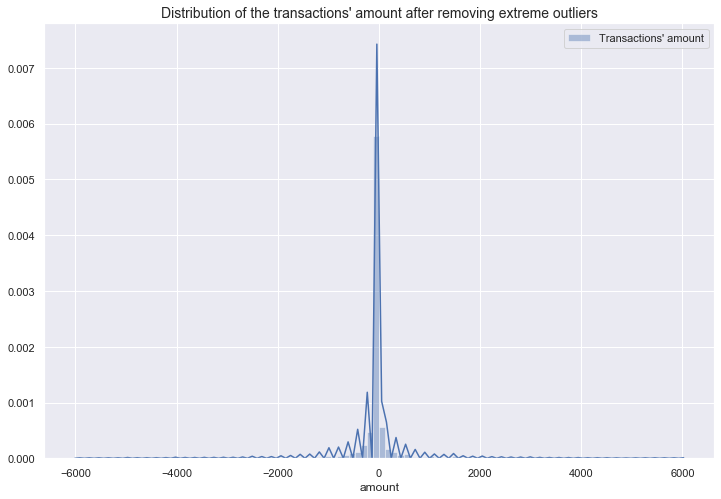

In [10]:
import scipy.stats as sps
                                 
amount_data = valid_transactions['amount']

mean = np.mean(amount_data)
median = np.median(amount_data)
std = np.std(amount_data)
kurtosis = sps.kurtosis(amount_data)
skew = sps.skew(amount_data)

print(f"Mean: {mean}")
print(f"Median: {median}")
print(f"Standard Deviation: {std}")
print(f"Kurtosis: {kurtosis}")
print(f"Skew: {skew}\n")

df_no_outliers = valid_transactions[(valid_transactions['amount']>mean-5*std) & (valid_transactions['amount']<mean+5*std)]

mean = np.mean(df_no_outliers['amount'])
median = np.median(df_no_outliers['amount'])
std = np.std(df_no_outliers['amount'])
kurtosis = sps.kurtosis(df_no_outliers['amount'])
skew = sps.skew(df_no_outliers['amount'])

print(f"Mean: {mean}")
print(f"Median: {median}")
print(f"Standard Deviation: {std}")
print(f"Kurtosis: {kurtosis}")
print(f"Skew: {skew}\n")

print(f"Number of transactions after: {df_no_outliers.shape[0]}")
print(f"Percentage Gone: {round((valid_transactions.shape[0] - df_no_outliers.shape[0])/valid_transactions.shape[0]*100, 2)}%")

plt.figure(figsize=(12, 8))
sns.distplot(df_no_outliers["amount"],
             label="Transactions' amount", bins=100)
plt.legend()
plt.title("Distribution of the transactions' amount after removing extreme outliers", fontsize=14)

I did reduce skew and kurtosis, but then I realized I had to forecast with data from one account at a time, so it made more sense to remove outliers according to mean and std from each account, instead of on the whole data.

In [11]:
def remove_outliers(df: pd.DataFrame, transaction_type: str) -> pd.DataFrame:

    if transaction_type == "expense":
        df = df[df['amount']<0]
        df['amount'] = abs(df['amount'])
    else:
        df = df[df['amount']>0]      
        
    df_transactions = (
        df.groupby(["account_id"])["amount"]
        .agg(["mean", "std"])
        .reset_index()
    )
    df = pd.merge(
        df,
        df_transactions,
        on=["account_id"],
        how="left",
        sort=False,
    )

    df["outlier"] = df["amount"] > df["mean"]+df["std"]*5
    
    return df

Number of transactions after: 165915
Percentage Gone: 1.16%


Text(0.5, 1.0, "Distribution of the transactions' amount after removing outliers per accounts")

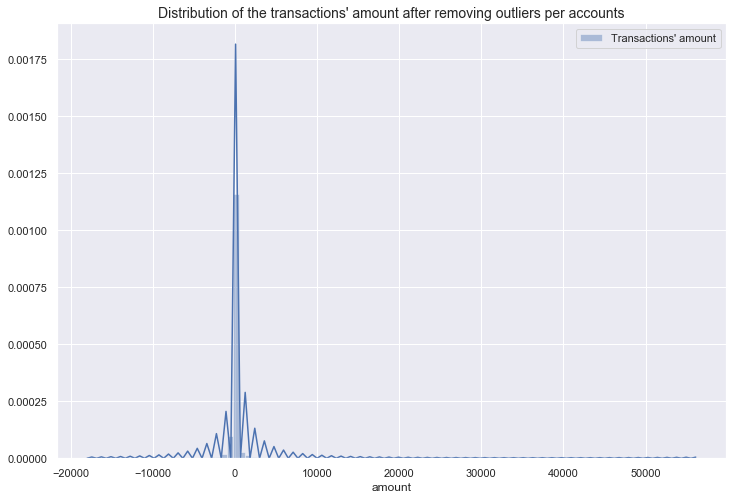

In [12]:
df_expenses = remove_outliers(df=valid_transactions, transaction_type="expense")
df_incomes = remove_outliers(df=valid_transactions, transaction_type="income")

df_incomes = df_incomes[~df_incomes["outlier"]]
df_expenses = df_expenses[~df_expenses["outlier"]]
df_expenses["amount"] = df_expenses["amount"] * (-1)
df_no_outliers_account = pd.concat([df_expenses, df_incomes])



print(f"Number of transactions after: {df_no_outliers_account.shape[0]}")
print(f"Percentage Gone: {round((valid_transactions.shape[0] - df_no_outliers_account.shape[0])/valid_transactions.shape[0]*100, 2)}%")

plt.figure(figsize=(12, 8))
sns.distplot(df_no_outliers_account["amount"],
             label="Transactions' amount", bins=100)
plt.legend()
plt.title("Distribution of the transactions' amount after removing outliers per accounts", fontsize=14)

In [13]:
valid_transactions = df_no_outliers_account
valid_transactions = valid_transactions.drop(["outlier", "mean", "std"], axis=1)

Text(0.5, 1.0, 'Distribution of account balances in euro')

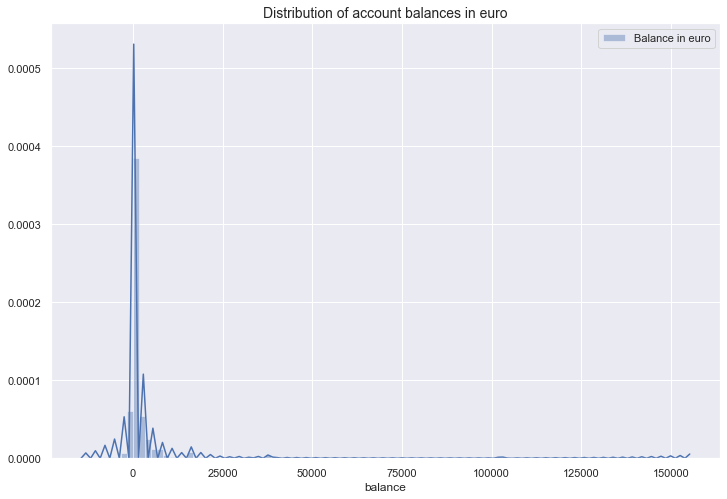

In [14]:
plt.figure(figsize=(12, 8))
sns.distplot(valid_accounts["balance"],
             label="Balance in euro", bins=100)
plt.legend()
plt.title("Distribution of account balances in euro", fontsize=14)

Clearly all the balances are not on the same scale, maybe I will create a feature based on % change for balance.

#### Check that no accounts are perfect duplicates

In [15]:
similar_accounts = user_accounts.groupby(by=["balance", "update_date"], as_index = False).size()
similar_accounts = similar_accounts[similar_accounts["size"]>1]

# block to get the similar accounts (same update_date and balance) in a list of lists
similar_accounts_lists = []
for i, sim_acc in similar_accounts.iterrows():
    
    group_of_similar_accounts = user_accounts.loc[(user_accounts["balance"]==sim_acc["balance"])
                            & (user_accounts["update_date"]==sim_acc["update_date"])]
    
    if not group_of_similar_accounts.empty:
        similar_accounts_lists.append(group_of_similar_accounts.index.values.tolist())
        
print(similar_accounts_lists)

[[215, 423], [116, 436], [5, 409], [201, 347], [256, 286], [123, 339], [122, 132, 297, 317], [20, 426], [16, 259], [34, 125], [254, 406], [232, 368], [177, 293, 420], [26, 378]]


In [16]:
# Here we check if two (or more) accounts have exactly the same transactions for different accounts
def check_transactions_similarity(valid_transactions: pd.DataFrame, similar_accounts_list: List[int]) -> List[int]:
    transactions_list = []
    ids_to_remove = []
    for account_id in similar_accounts_list:
        transactions = valid_transactions.loc[
            valid_transactions["account_id"]==account_id].sort_values(by=['amount', 'date'])
        
        transactions.drop(['account_id'], axis=1, inplace=True)
        transactions.reset_index(drop=True, inplace=True)
        transactions_list.append(transactions)
    
    for i, transactions in enumerate(transactions_list):
        if len(transactions_list) > i+1:
            if transactions_list[i].shape[0] == transactions_list[i+1].shape[0]:
                comparisons = []
                
                for k, row in transactions_list[i].iterrows():
                    comparisons.append(row.equals(transactions_list[i+1].iloc[k]))
                if all(comparisons):
                    ids_to_remove.append(similar_accounts_list[i+1]) 
                    print("Account number {:n} is identical and will be removed".format(similar_accounts_list[i+1]))
            else:
                "not equal"

    return ids_to_remove


accounts_to_be_removed = []
for similar_accounts_list in similar_accounts_lists:
    accounts_to_be_removed.append(check_transactions_similarity(valid_transactions, similar_accounts_list))
    
valid_transactions = valid_transactions.loc[~valid_transactions['account_id'].isin(accounts_to_be_removed)]
valid_accounts = valid_accounts.loc[~valid_accounts['id'].isin(accounts_to_be_removed)]

print(valid_transactions.loc[valid_transactions['account_id'].isin(accounts_to_be_removed)])
print(valid_accounts.loc[valid_accounts['id'].isin(accounts_to_be_removed)])

Account number 436 is identical and will be removed
Account number 409 is identical and will be removed
Account number 339 is identical and will be removed
Account number 132 is identical and will be removed
Account number 297 is identical and will be removed
Account number 317 is identical and will be removed
Account number 406 is identical and will be removed
Account number 368 is identical and will be removed
Account number 293 is identical and will be removed
Account number 420 is identical and will be removed
Account number 378 is identical and will be removed
Empty DataFrame
Columns: [date, amount, account_id]
Index: []
Empty DataFrame
Columns: [id, balance, user_id]
Index: []


The duplicate accounts have been deleted successfully

#### Analysis of monthly/weekly transactions for each account

In [17]:
def get_account_incomes(df: pd.DataFrame) -> pd.DataFrame:
    account_id = df['account_id'].iloc[0]
    df = df.sort_values(by="date", ascending=True)[["date", "amount"]]
    df = df[df['amount']>0]
    df["account_id"] = account_id
    return df

all_income_data = []    
for _, df in valid_transactions.groupby("account_id"):
    all_income_data.append(get_account_incomes(df))


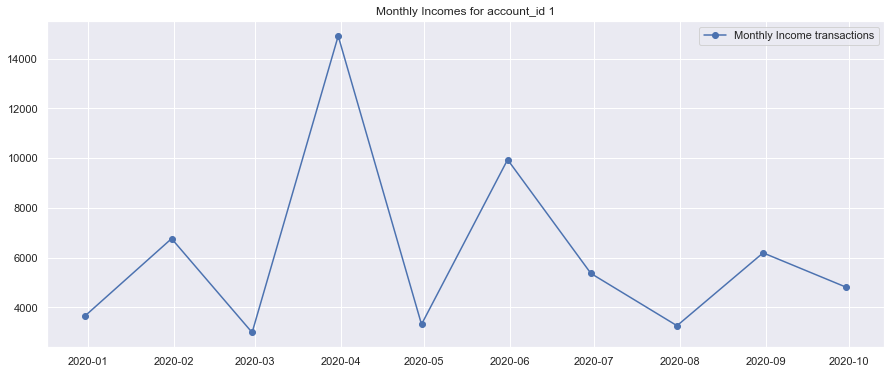

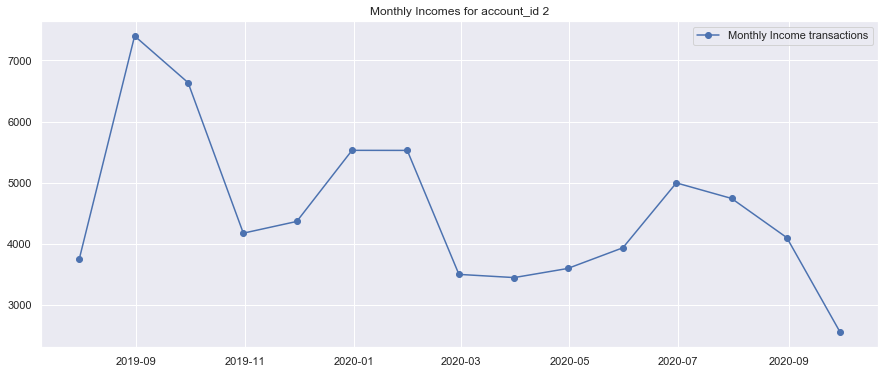

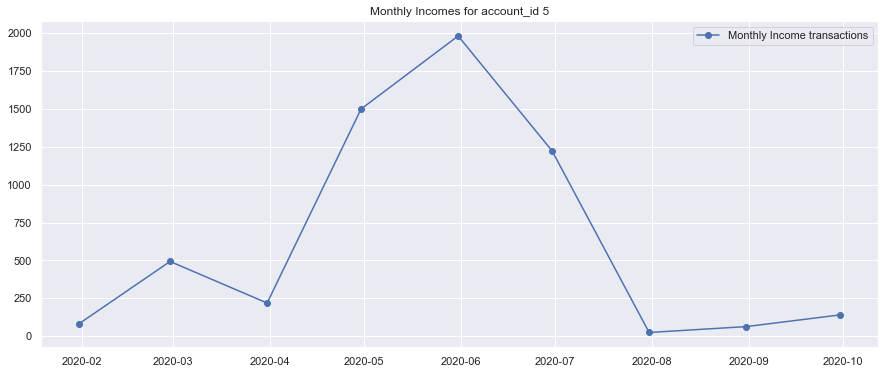

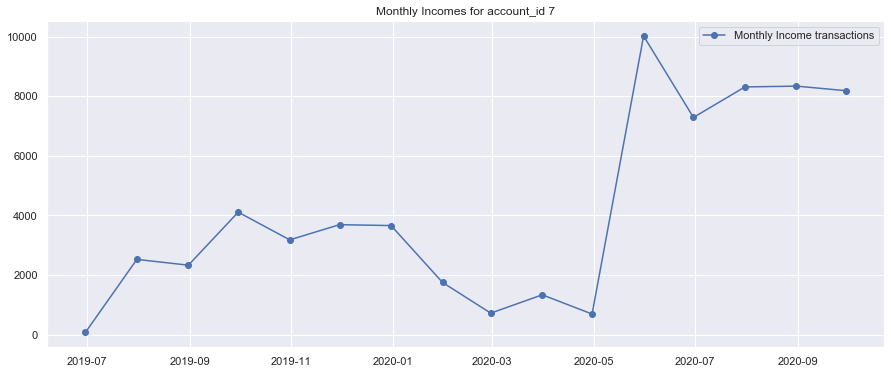

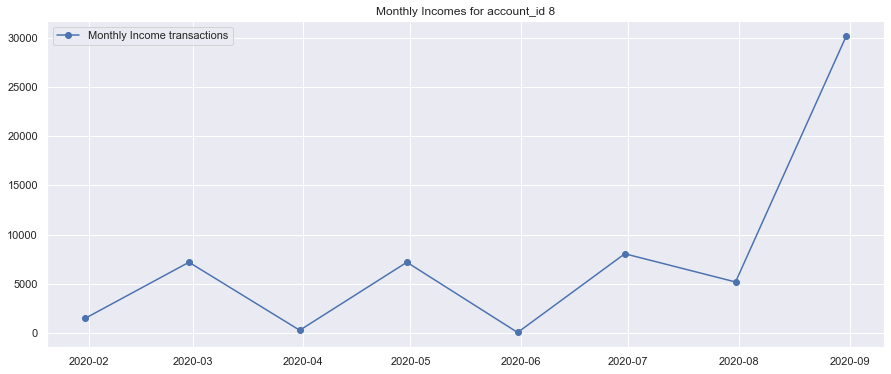

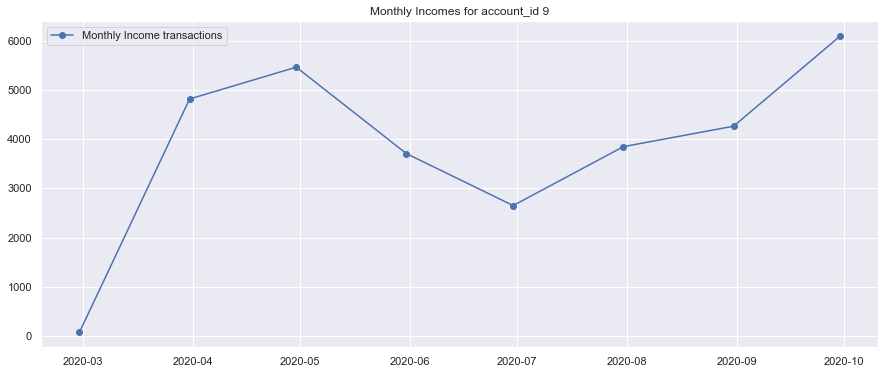

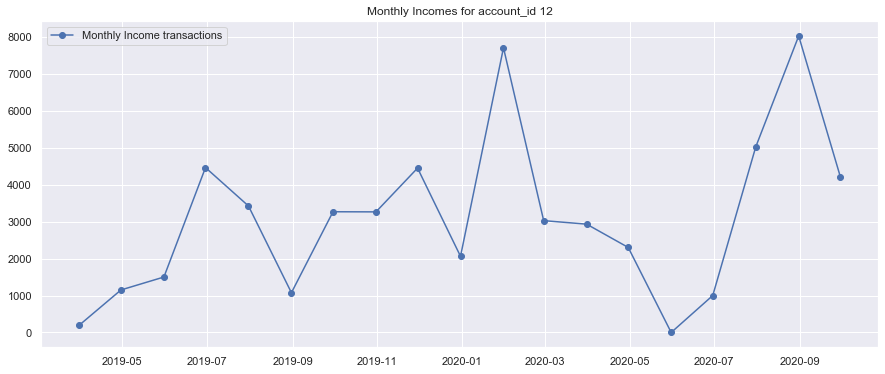

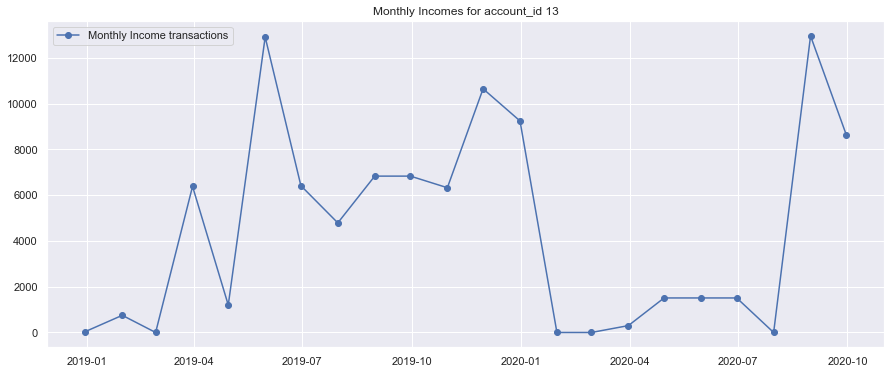

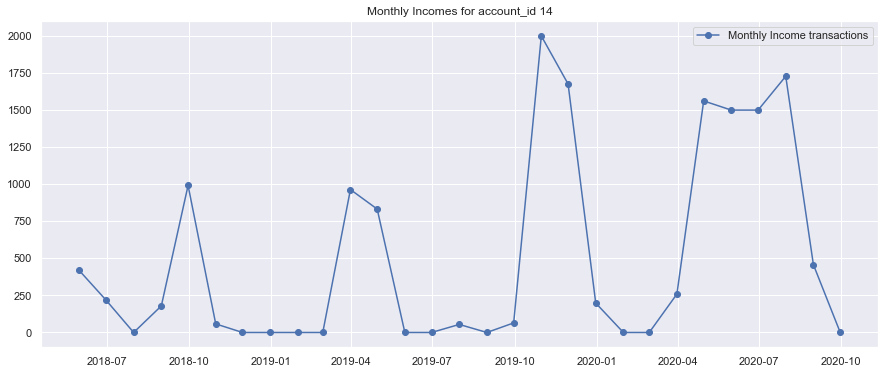

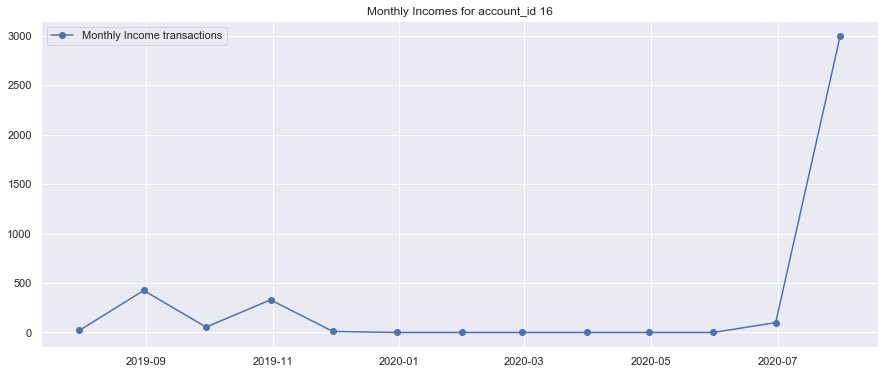

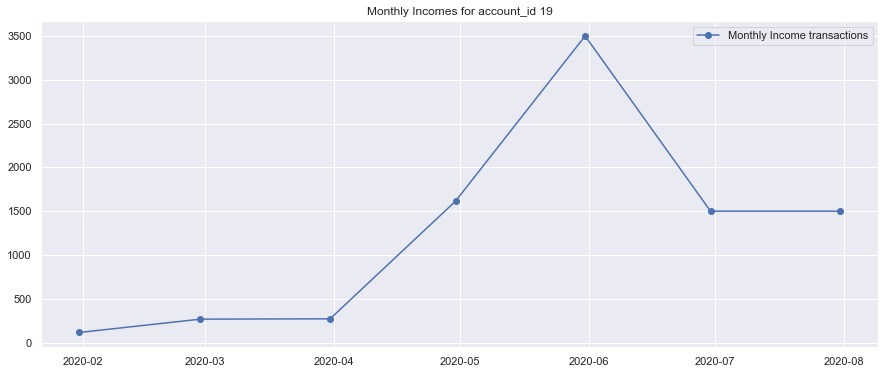

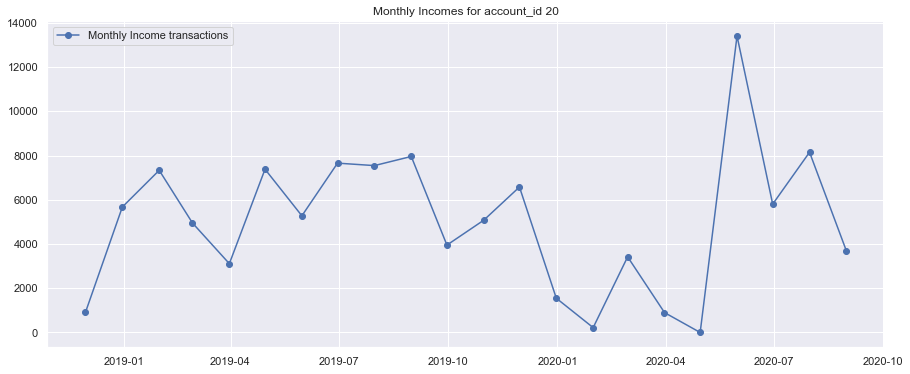

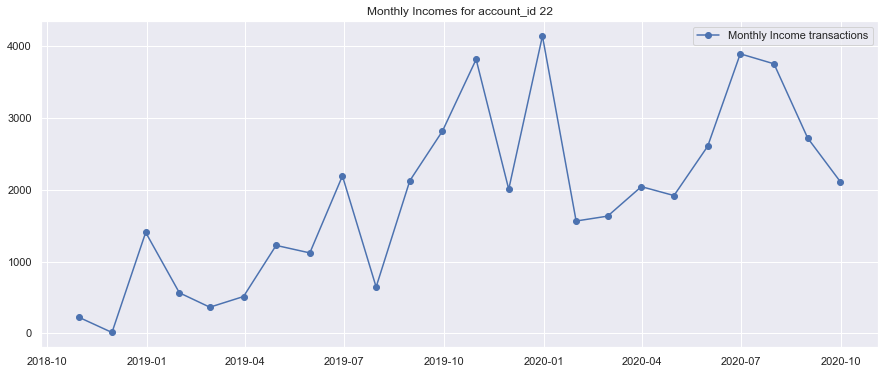

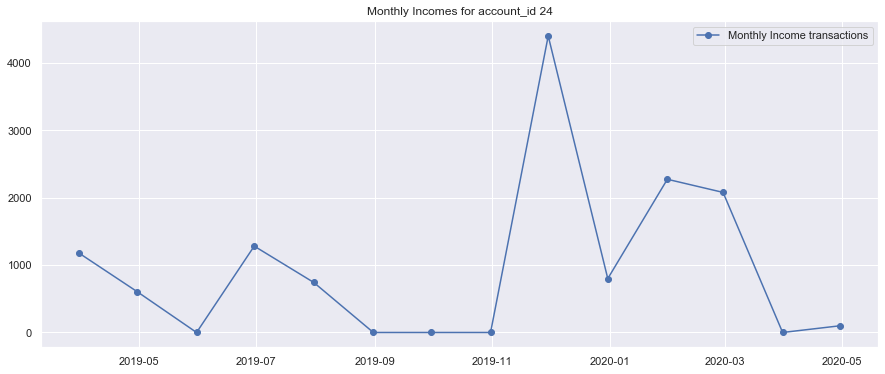

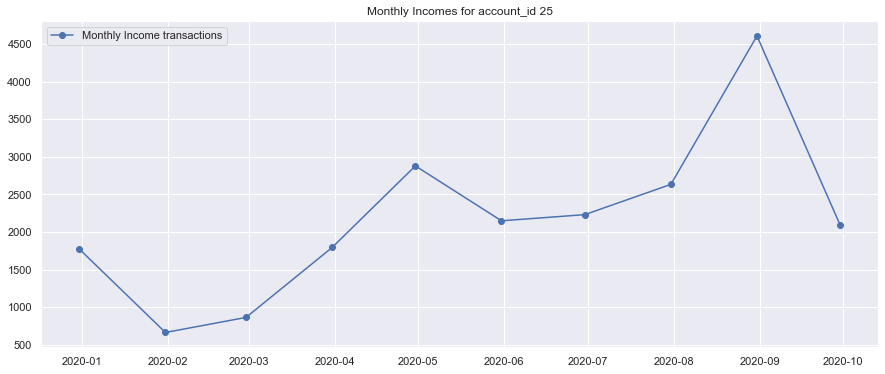

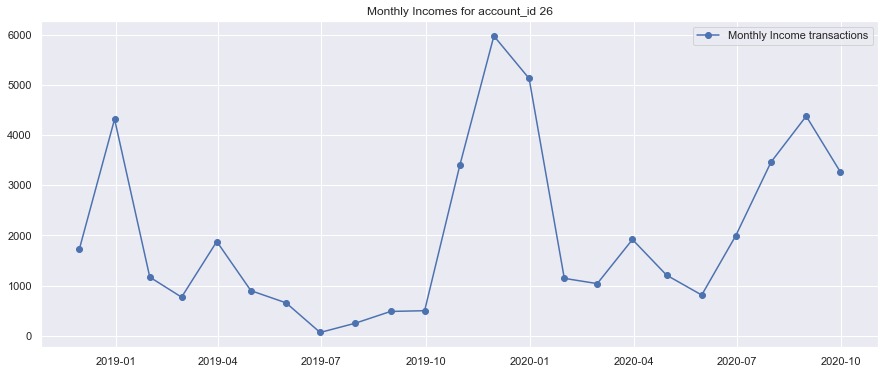

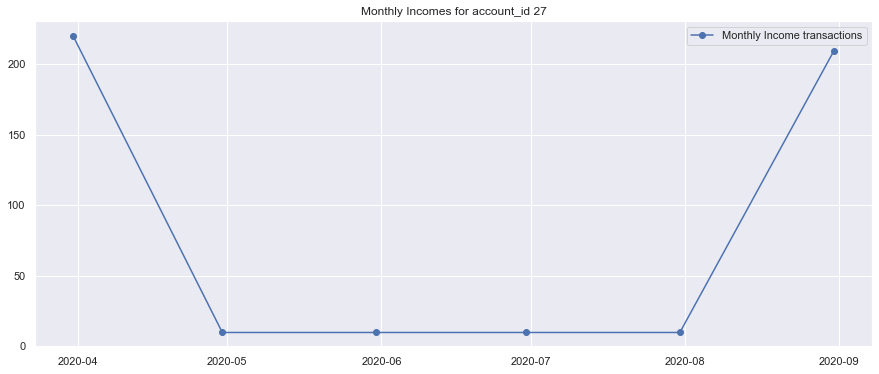

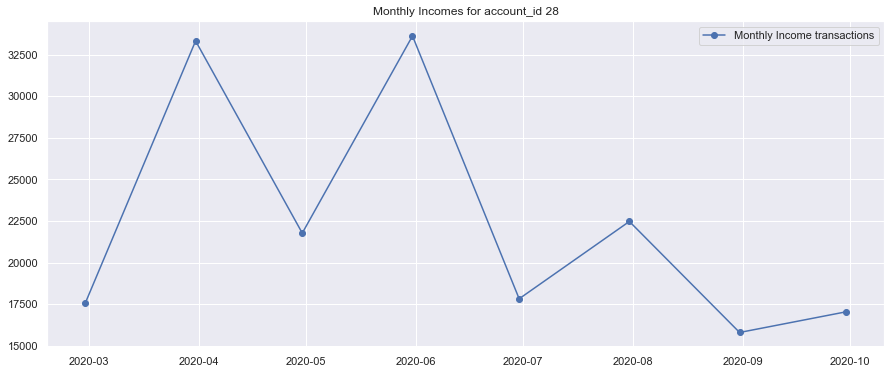

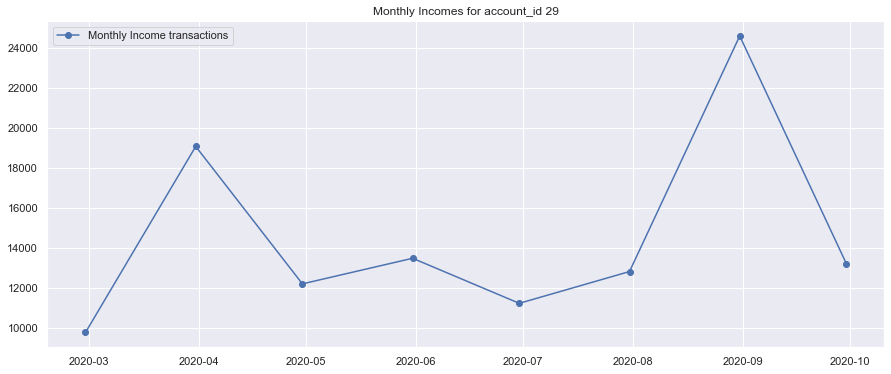

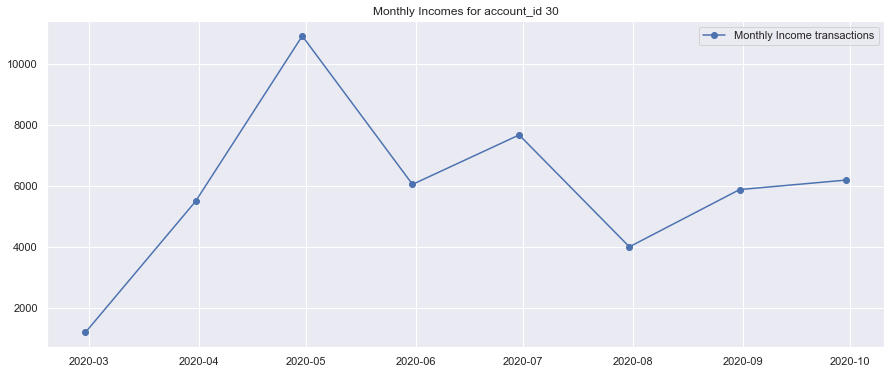

In [22]:
resampled_incomes = []
for income_df in all_income_data[:20]:
    if income_df.shape[0] > 0:
        
        account_id = income_df['account_id'].iloc[0]

        income_df = income_df.sort_values(by="date", ascending=True)[["date", "amount"]]
        income_df = income_df.set_index("date", drop=True)

        income_df = income_df.resample("M").agg('sum').reset_index()
        income_df["account_id"] = account_id

        plt.figure(figsize=(15, 6))
        plt.plot(
        income_df['date'],
        income_df['amount'],
        "-o",
        label="Monthly Income transactions")
        plt.title("Monthly Incomes for account_id {:n}"
                 .format(income_df['account_id'].iloc[0])
                 )

        plt.legend()
        resampled_incomes.append(income_df)

In [23]:
def get_account_expenses(df: pd.DataFrame) -> pd.DataFrame:
    account_id = df['account_id'].iloc[0]
    df = df.sort_values(by="date", ascending=True)[["date", "amount"]]
    df = df[df['amount']<0]
    df["account_id"] = account_id
    return df

all_outgoing_data = []    
for _, df in transactions.groupby("account_id"):
    all_outgoing_data.append(get_account_expenses(df))


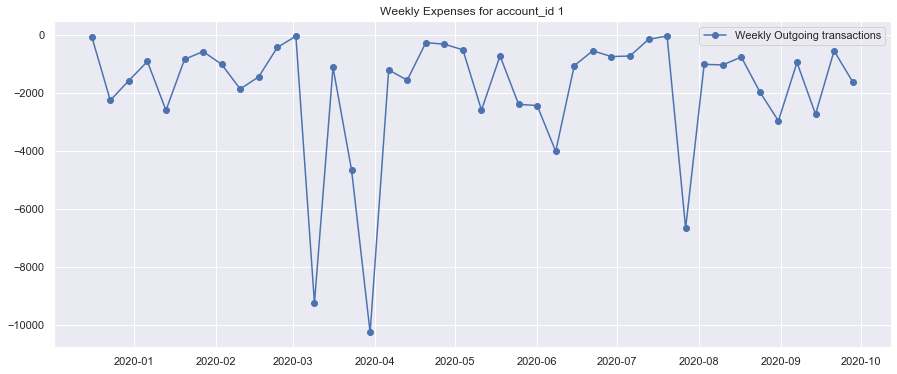

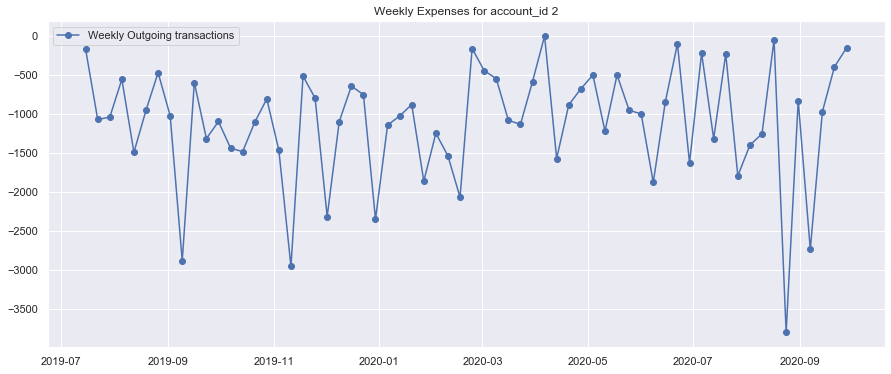

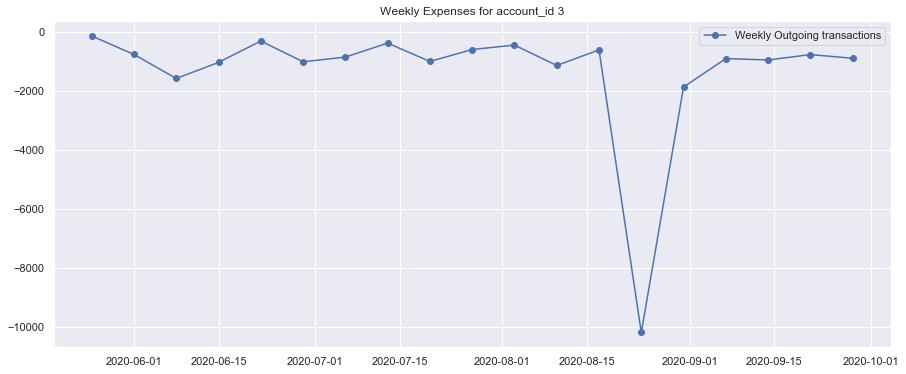

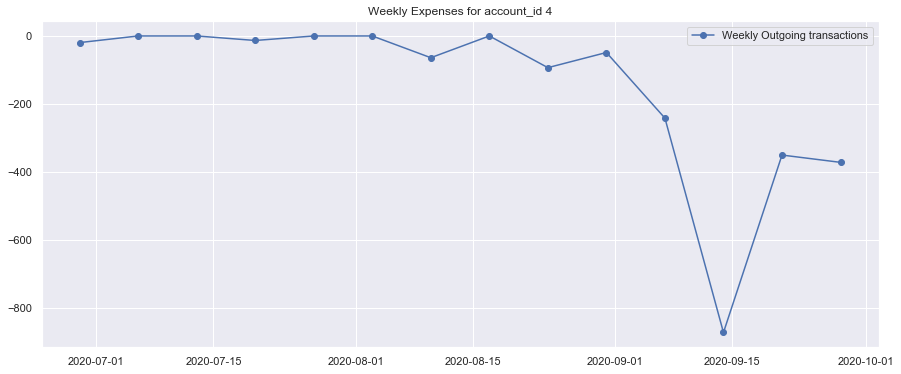

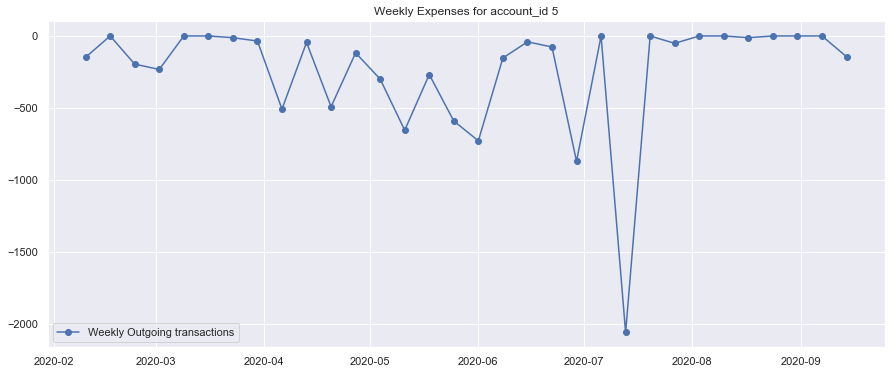

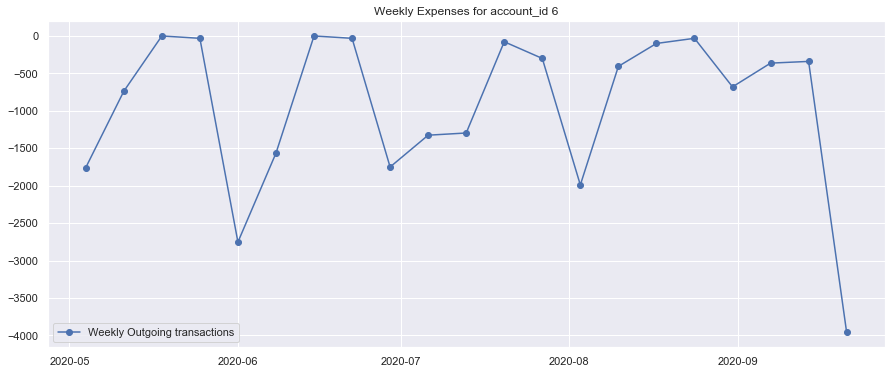

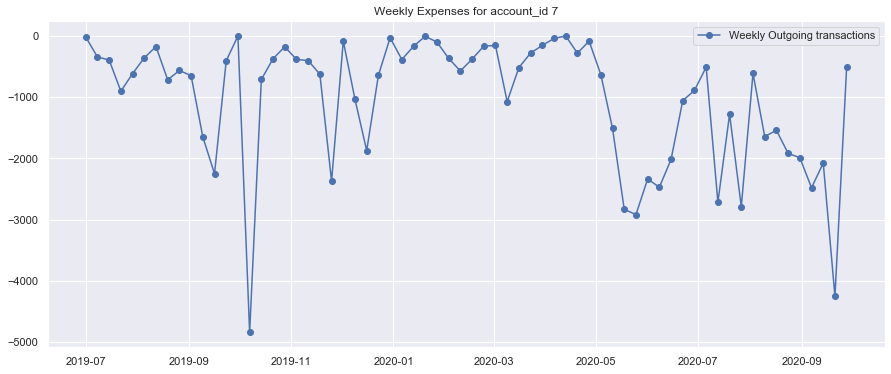

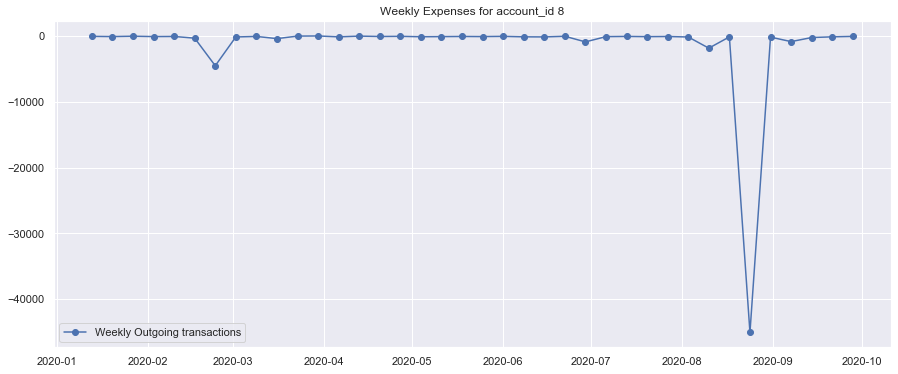

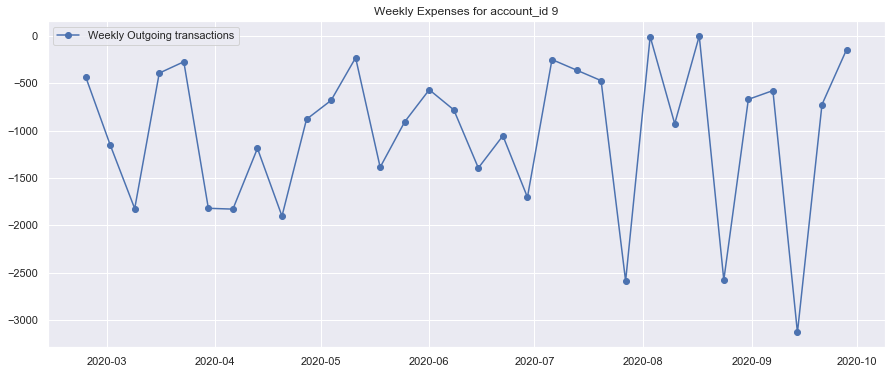

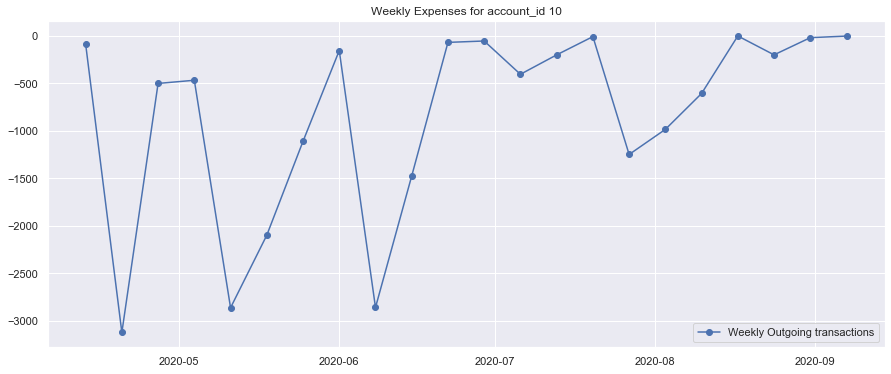

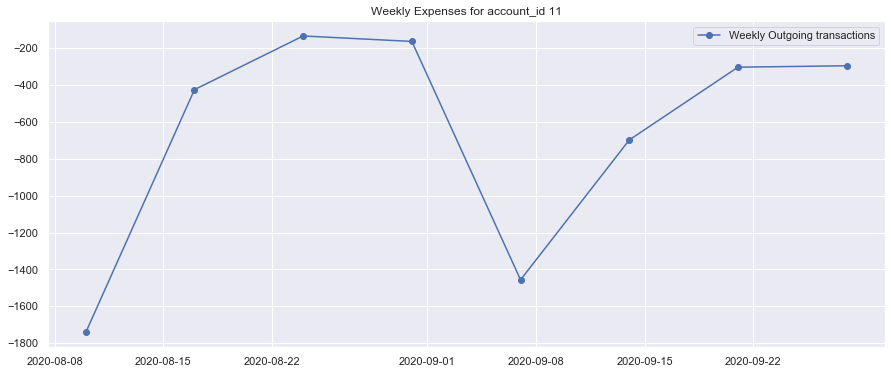

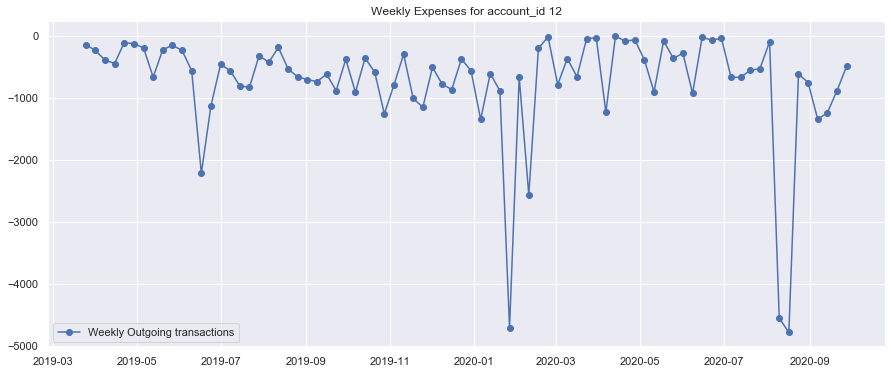

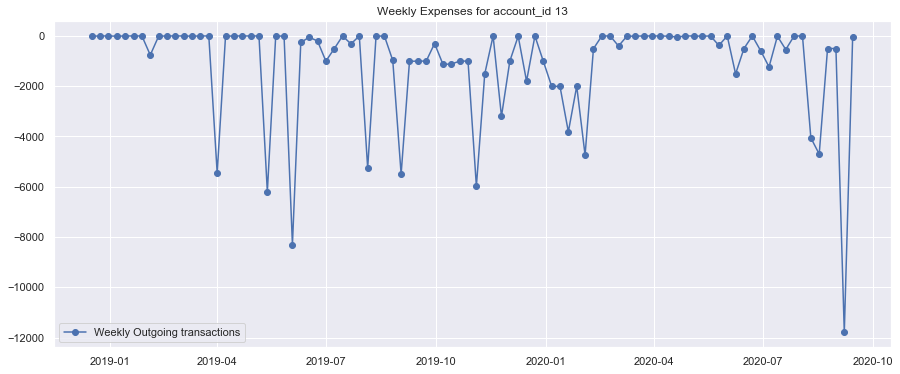

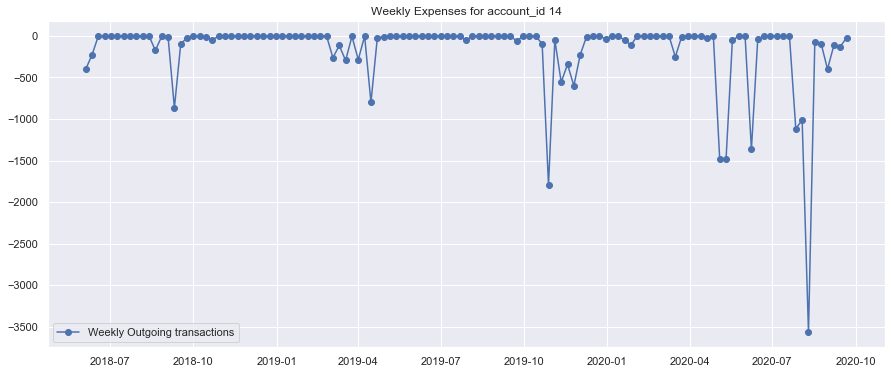

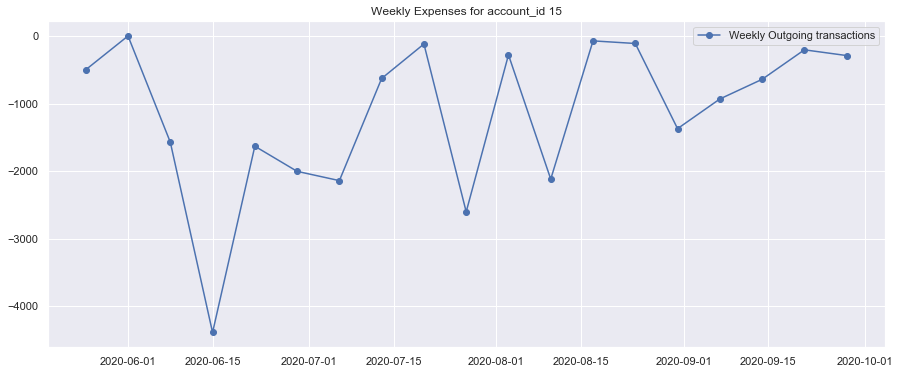

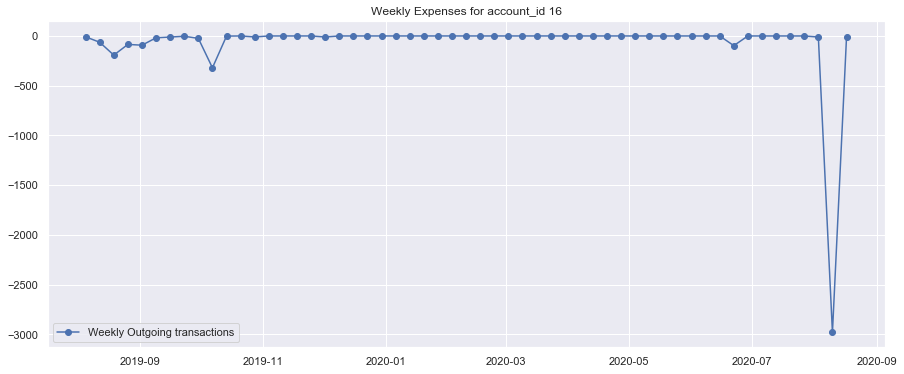

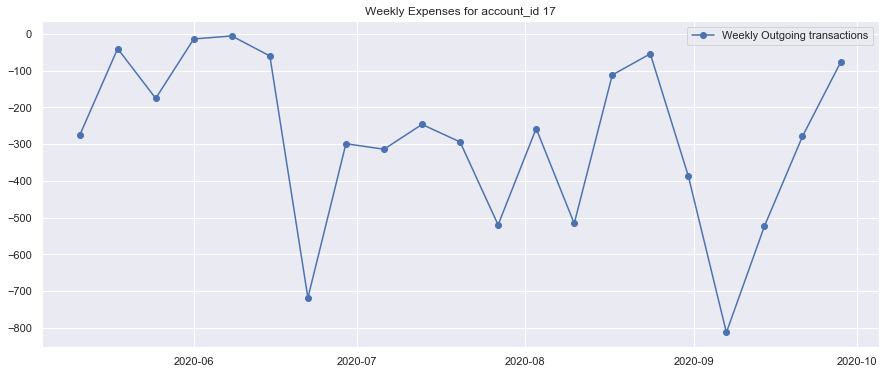

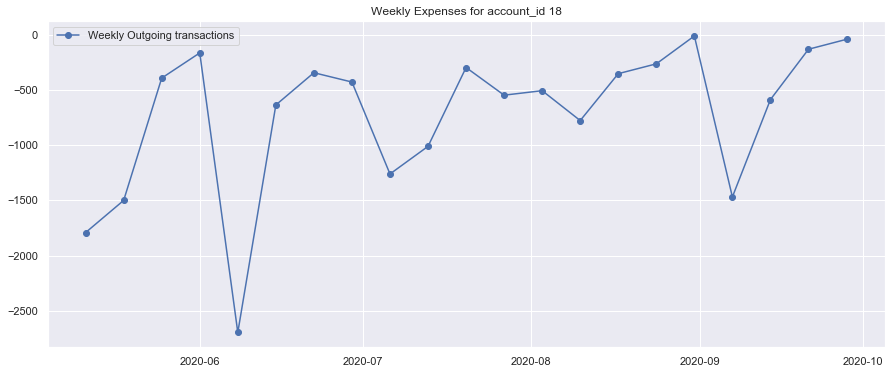

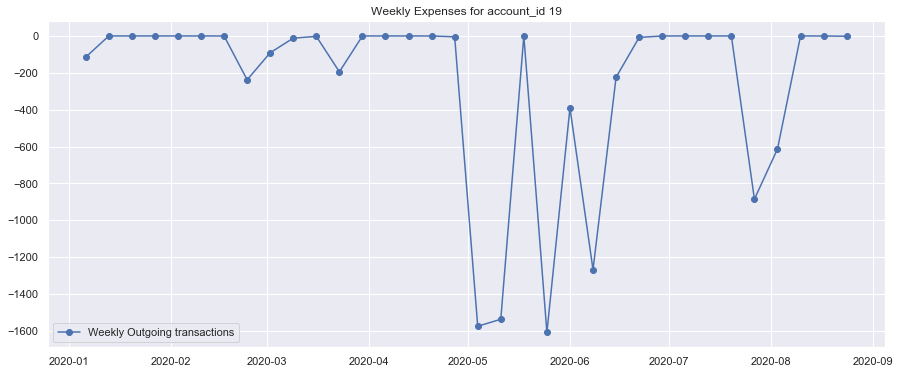

In [24]:
resampled_outgoings = []
for outgoing_df in all_outgoing_data[:20]:
    if outgoing_df.shape[0] > 0:
        
        account_id = outgoing_df['account_id'].iloc[0]

        outgoing_df = outgoing_df.sort_values(by="date", ascending=True)[["date", "amount"]]
        outgoing_df = outgoing_df.set_index("date", drop=True)

        outgoing_df = outgoing_df.resample("W-MON").agg('sum').reset_index()
        outgoing_df["account_id"] = account_id
        
        plt.figure(figsize=(15, 6))
        plt.plot(
        outgoing_df['date'],
        outgoing_df['amount'],
        "-o",
        label="Weekly Outgoing transactions")
        plt.title("Weekly Expenses for account_id {:n}"
                 .format(outgoing_df["account_id"].iloc[0])
                 )

        plt.legend()
        resampled_outgoings.append(outgoing_df)

A lot of missing data that will need to be accounted for. Other than that, some account's expenses exhibit monthly seasonality, like account_id 233.

#### Explore amount of transactions by user and by NAF code to identify potential patterns and see their distribution

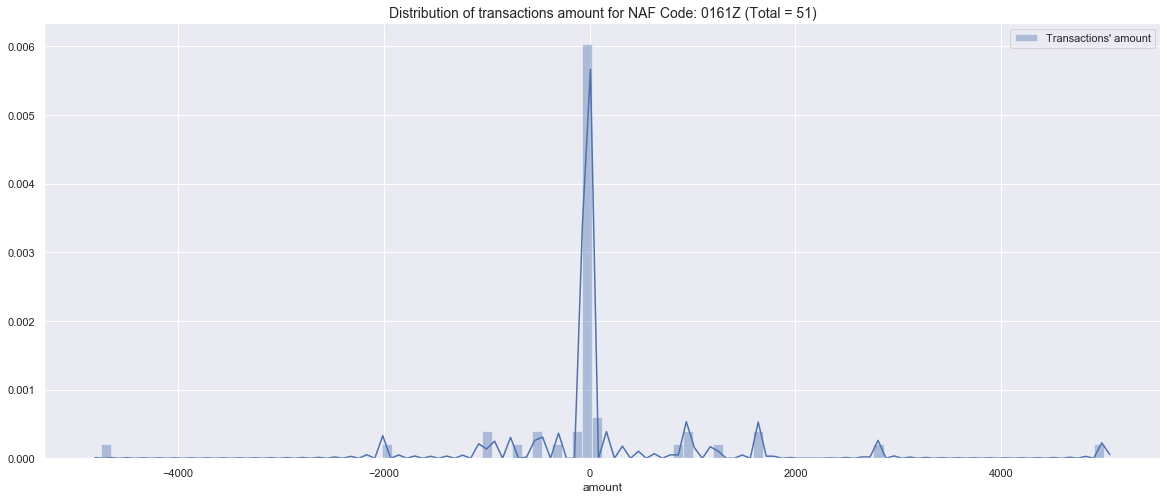

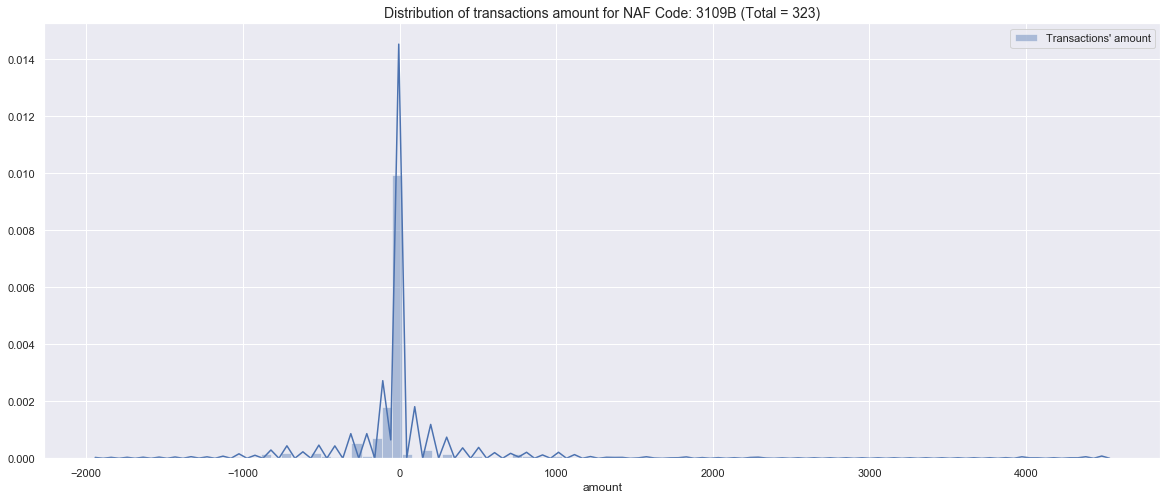

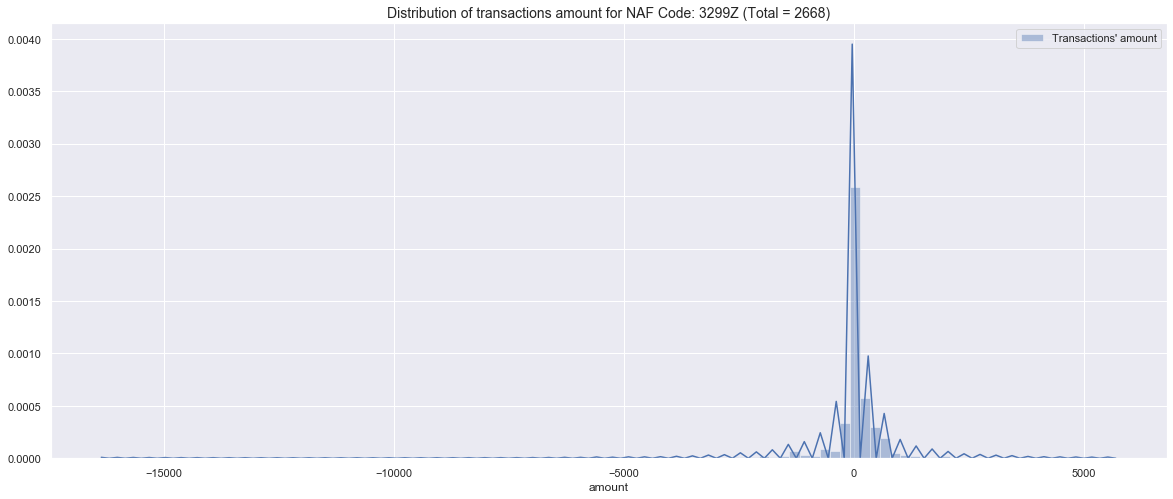

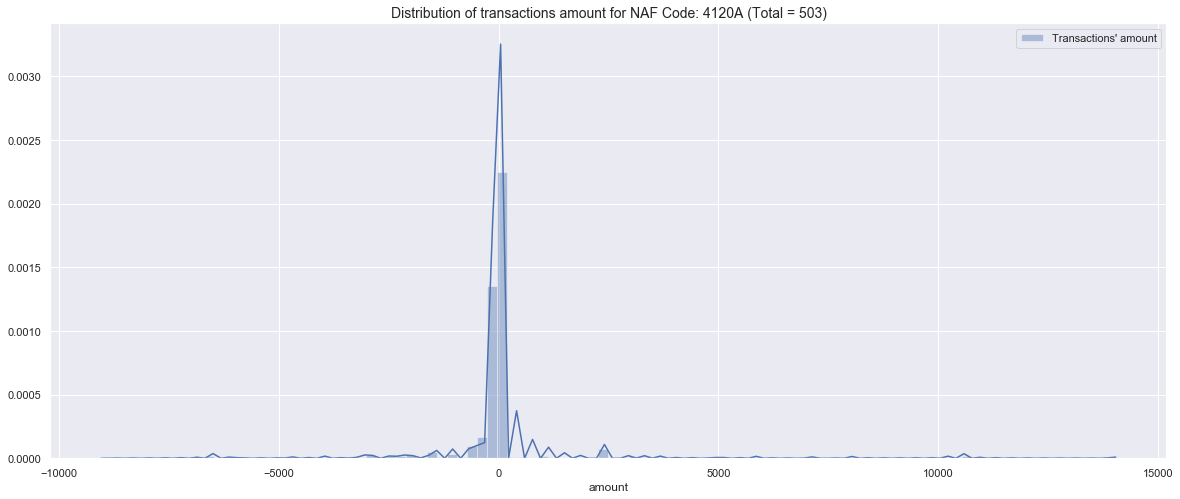

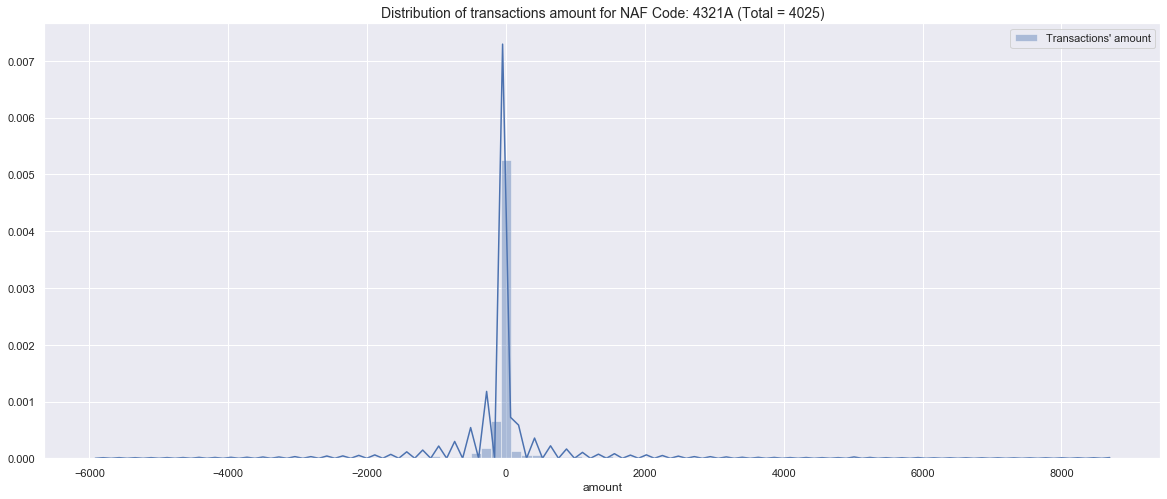

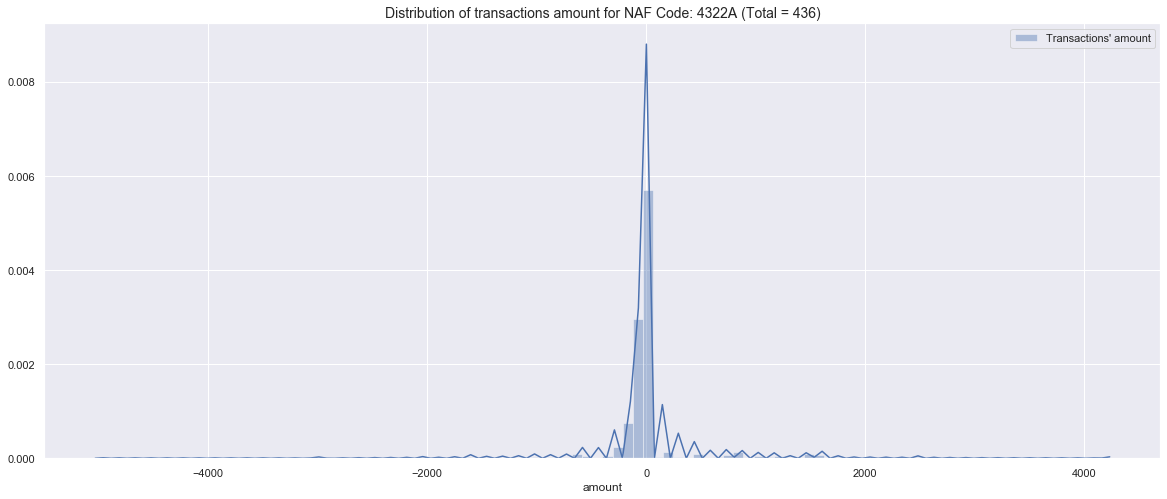

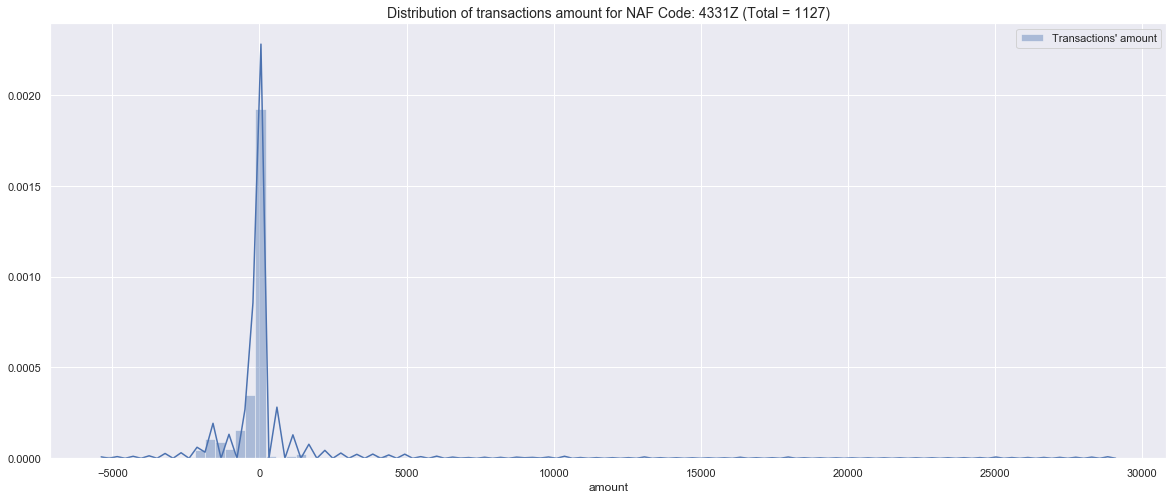

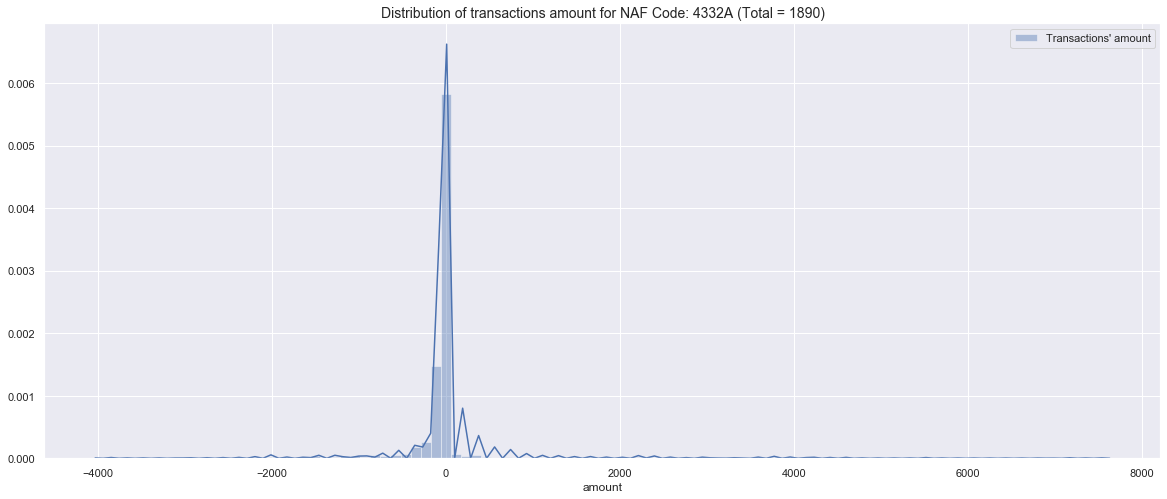

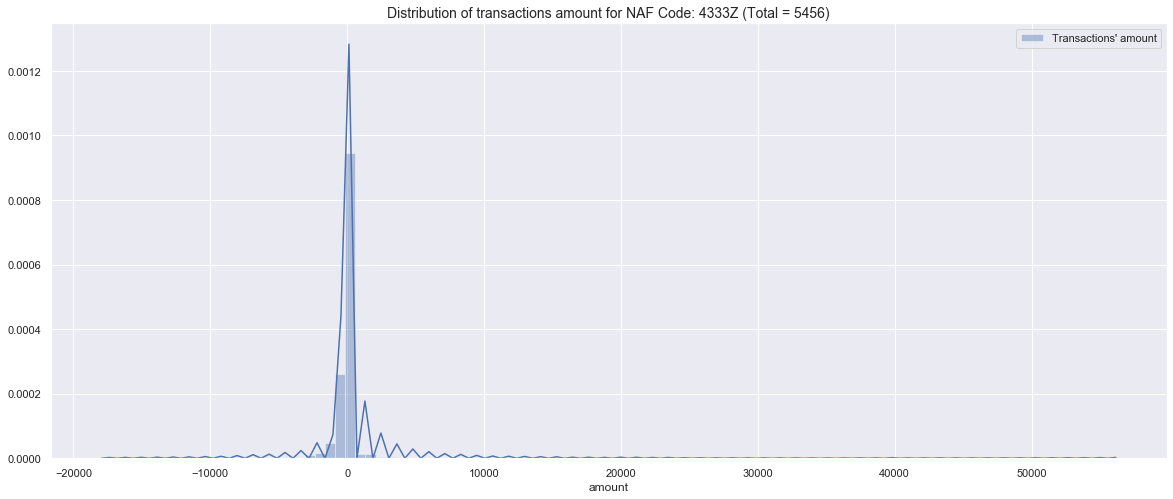

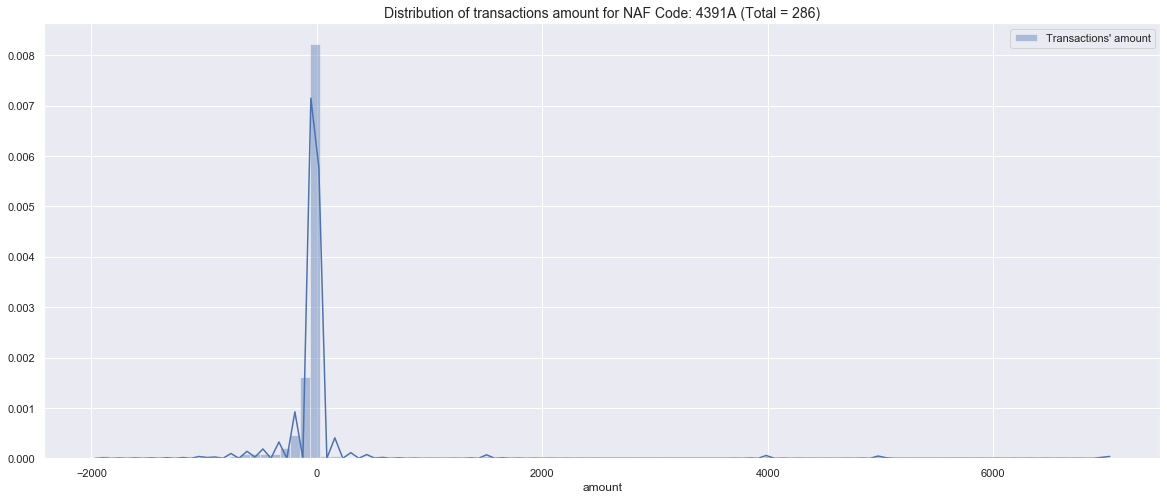

In [26]:
count=0
for naf_id, naf_transactions in user_accounts_transactions.groupby(by='business_NAF_code'):
    if count < 10:
        plt.figure(figsize=(20, 8))

        sns.distplot(naf_transactions["amount"],
                 label="Transactions' amount", bins = 100)
        plt.legend()
        plt.title("Distribution of transactions amount for NAF Code: "+str(naf_id)+" (Total = "+str(naf_transactions["amount"].count())+")"
                  , fontsize=14)
    count+=1

In [27]:
monthly_income = pd.concat([resampled_income for resampled_income in resampled_incomes])
weekly_outgoing = pd.concat([resampled_outgoing for resampled_outgoing in resampled_outgoings])

user_accounts_incomes = monthly_income.join(user_accounts, 'account_id')
user_accounts_outgoings = weekly_outgoing.join(user_accounts, 'account_id')


Text(0.5, 1.0, 'Distribution of mean monthly income by naf_code')

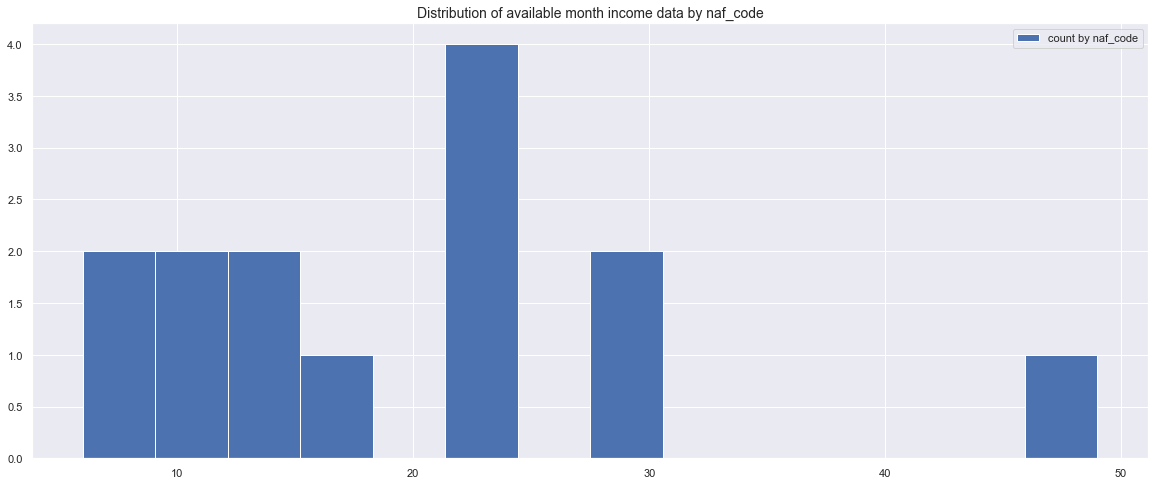

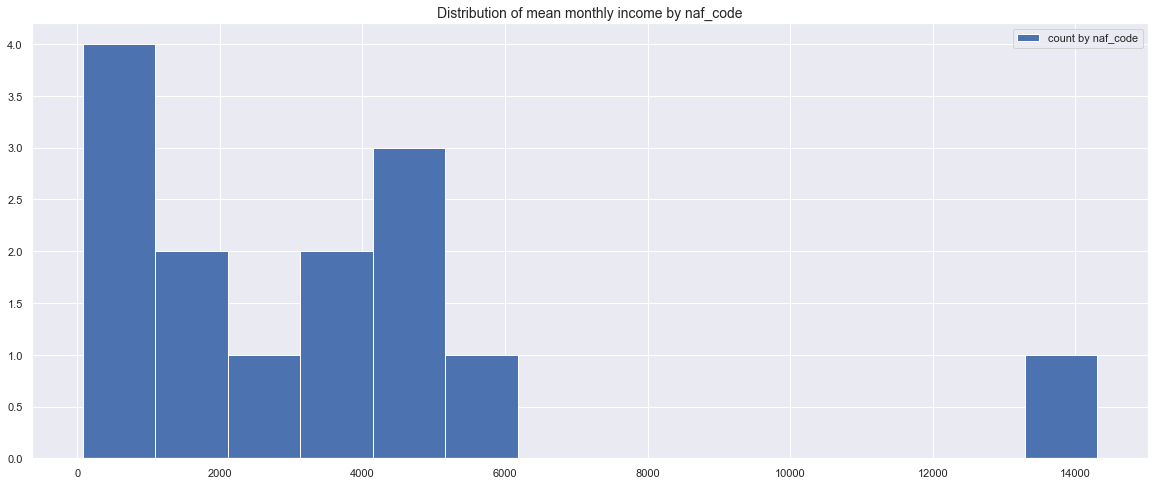

In [28]:
naf_stats =  user_accounts_incomes.groupby(by='business_NAF_code').agg({"amount": ["mean", "count"]})["amount"]
# naf_stats = naf_stats["amount"]

plt.figure(figsize=(20, 8))
plt.hist(naf_stats["count"],
         label="count by naf_code", bins = naf_stats["count"].shape[0])
plt.legend()
plt.title("Distribution of available month income data by naf_code"
          , fontsize=14)

plt.figure(figsize=(20, 8))
plt.hist(naf_stats["mean"],
         label="count by naf_code", bins = naf_stats["mean"].shape[0])
plt.legend()
plt.title("Distribution of mean monthly income by naf_code"
          , fontsize=14)
    

Text(0.5, 1.0, 'Distribution of mean weekly outgoing by naf_code')

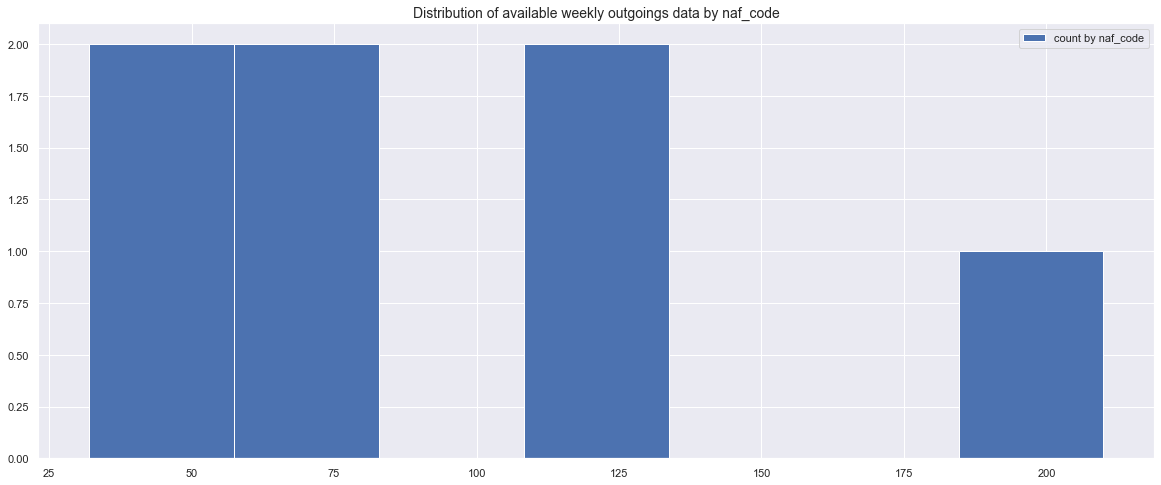

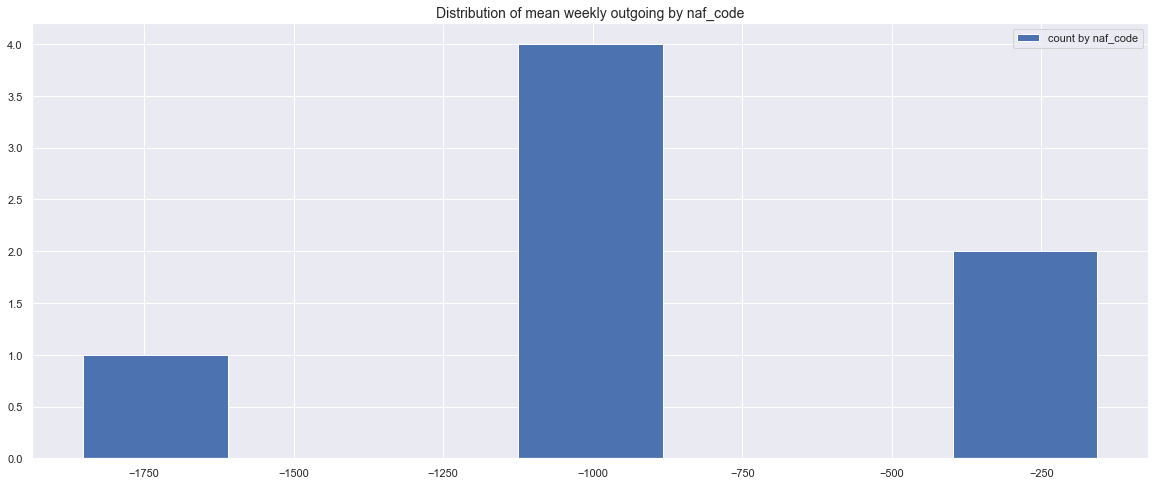

In [29]:
naf_stats =  user_accounts_outgoings.groupby(by='business_NAF_code').agg({"amount": ["mean", "count"]})["amount"]
# naf_stats = naf_stats["amount"]

plt.figure(figsize=(20, 8))
plt.hist(naf_stats["count"],
         label="count by naf_code", bins = naf_stats["count"].shape[0])
plt.legend()
plt.title("Distribution of available weekly outgoings data by naf_code"
          , fontsize=14)

plt.figure(figsize=(20, 8))
plt.hist(naf_stats["mean"],
         label="count by naf_code", bins = naf_stats["mean"].shape[0])
plt.legend()
plt.title("Distribution of mean weekly outgoing by naf_code"
          , fontsize=14)
    

#### Check how many incoming vs outgoing transactions there are, to potentially make a decision as to which problem would be easier to solve (more data could mean better predictions)

In [30]:
amount_of_incomes = valid_transactions[valid_transactions['amount']>0].shape[0]
print("amount of incoming transactions : {:n}".format(amount_of_incomes))

amount_of_outgoings = valid_transactions[valid_transactions['amount']<0].shape[0]
print("amount_of_outgoing transactions : {:n}".format(amount_of_outgoings))

amount_of_nulls = valid_transactions[valid_transactions['amount']==0].shape[0]
print("amount of transactions with 0€ : {:n}".format(amount_of_nulls))

amount of incoming transactions : 27757
amount_of_outgoing transactions : 138158
amount of transactions with 0€ : 0


Since we will only look at incoming or outgoing amounts, and they're not very numerous, we can afford to delete 0€ transactions

In [31]:
valid_transactions = valid_transactions[valid_transactions["amount"] != 0]
print(valid_transactions.shape[0])

165915


#### Check if there are duplicate transactions

In [32]:
duplicate_transactions = valid_transactions.groupby(
    valid_transactions.columns.tolist(), as_index = False).size()

duplicate_transactions = duplicate_transactions.loc[duplicate_transactions['size'] > 1]
duplicate_transactions['size'] = duplicate_transactions['size']-1
same_day_duplicates = duplicate_transactions.sort_values(by="size").shape[0]
all_duplicates = duplicate_transactions['size'].sum()

print("number of day with same amount transactions: {:n}".format(same_day_duplicates))
print("number of same amount and same day transactions: {:n}".format(all_duplicates))


absolute_valid_transactions = valid_transactions.copy()
absolute_valid_transactions['amount'] = absolute_valid_transactions['amount'].abs()
duplicate_transactions_abs = absolute_valid_transactions.groupby(
    valid_transactions.columns.tolist(), as_index = False).size()
      
duplicate_transactions_abs = duplicate_transactions_abs.loc[duplicate_transactions_abs['size'] > 1]
duplicate_transactions_abs['size'] = duplicate_transactions_abs['size']-1
all_abs_duplicates = duplicate_transactions_abs['size'].sum()
same_day_abs_duplicates = duplicate_transactions_abs.sort_values(by="size").shape[0]

print("number of day with same absolute amount transactions: {:n}".format(same_day_abs_duplicates))
print("number of same absolute amount and same day transactions: {:n}".format(all_abs_duplicates))

print("number of transactions that are same opposite amounts on same day: {:n}".format(all_abs_duplicates-all_duplicates))

number of day with same amount transactions: 5763
number of same amount and same day transactions: 8553
number of day with same absolute amount transactions: 6934
number of same absolute amount and same day transactions: 10010
number of transactions that are same opposite amounts on same day: 1457


I also checked for duplicates with absolute values, to see if there was a lot of temporary transactions like sending 500€ to one of your accounts to then pay something with it. (+500 then -500)

These transactions might be skewing the forecast, because such transactions are probably not seasonal like utilities or mortgage payments.
They also affect any process that will analyse only incomings or only outgoings, because only one of the transactions pair will be taken into account.
With that said, there are apparently only a maximum of 1498 transactions over the total ~170k that are in this case.
Without knowing more about the accounts and what the transactions could be, and knowing how little of the data they represent, I decided not to delete them.

In [33]:

print(valid_transactions)

            date   amount  account_id
0     2019-12-16   -29.09           1
1     2019-12-16   -14.00           1
2     2019-12-17   -94.50           1
3     2019-12-17   -21.11           1
4     2019-12-17 -1000.00           1
...          ...      ...         ...
27893 2020-08-31   133.93         439
27894 2020-09-03  1500.00         439
27895 2020-09-04   177.55         439
27896 2020-09-07    58.69         439
27897 2020-09-14    13.82         439

[165915 rows x 3 columns]


In [34]:
valid_transactions.to_csv('data/valid_transactions.csv', index_label="id")
valid_accounts.to_csv('data/valid_accounts.csv', index = False)
valid_users.to_csv('data/valid_users.csv', index = False)

Now that we have explored the data and removed unwanted data, in the next notebook we will go into further detail, try to come up with new features and try to see if we can find some seasonality or stationarity in the data.